In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from Utils.dataset import PreloadedDataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


In [2]:
# device = torch.device('cuda') if torch.cuda.is_available() else "cpu"ArithmeticError
device = torch.device('cpu')
device

device(type='cpu')

Loaded MNIST with 8 samples


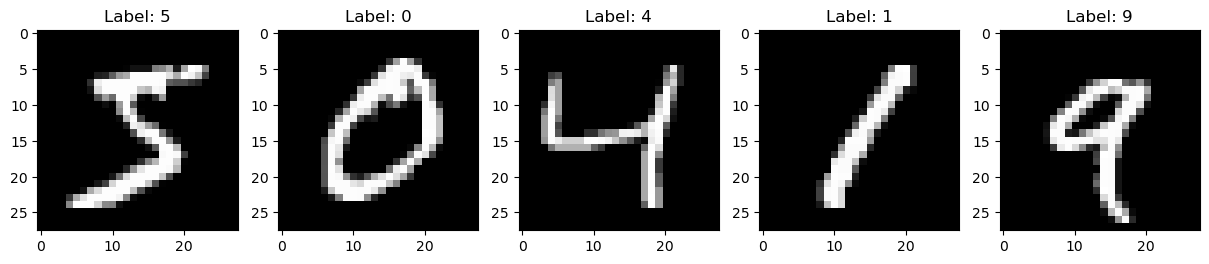

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

subset_size = 8
raw_dataset = datasets.MNIST(root="../Datasets/", train=True, transform=transform, download=False)
raw_dataset = torch.utils.data.Subset(raw_dataset, range(subset_size))

positive_dataset = PreloadedDataset.from_dataset(raw_dataset, transforms.ToTensor(), device)
print(f'Loaded MNIST with {len(positive_dataset)} samples')
# show first samples
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.squeeze(positive_dataset[i][0].numpy()), cmap='gray')
    axs[i].set_title(f"Label: {positive_dataset[i][1]}")
plt.show()

In [4]:
def mix_images(x1, x2, steps=10):
    mask = torch.bernoulli(torch.ones((28,28))*0.5).unsqueeze(0).unsqueeze(0)
    # blur  with a filter of the form [1/4, 1/2, 1/4] in both horizontal and veritical directions
    filter_h = torch.tensor([[1/4, 1/2, 1/4]])
    filter_v = torch.tensor([[1/4], [1/2], [1/4]])
    for _ in range(5):
        mask = F.conv2d(mask, filter_h.unsqueeze(0).unsqueeze(0), padding='same')
        mask = F.conv2d(mask, filter_v.unsqueeze(0).unsqueeze(0), padding='same')

    
    # threshold at 0.5
    mask_1 = mask > 0.5
    mask_2 = mask <= 0.5

    out = x1*mask_1 + x2*mask_2
    return out.squeeze(0)

Loaded MNIST with 8 samples


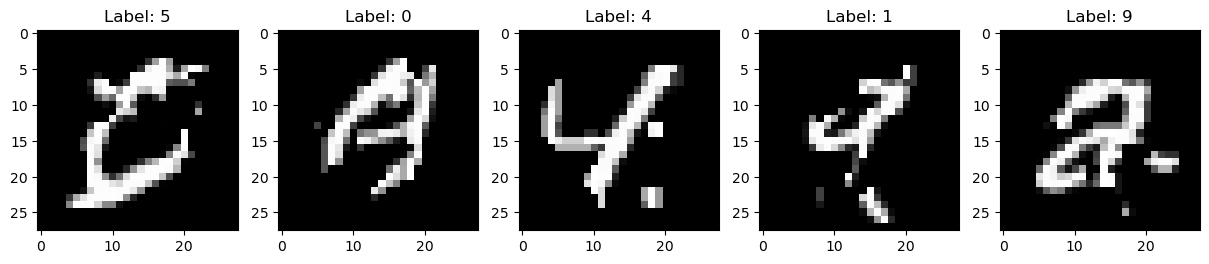

In [5]:
# Create second dataset using the mix func to build negative examples
negative_dataset = PreloadedDataset.from_dataset(raw_dataset, transforms.ToTensor(), device)
print(f'Loaded MNIST with {len(negative_dataset)} samples')

for i in range(len(negative_dataset)):
    j = i + 1 if i < len(negative_dataset) - 1 else 0
    negative_dataset.transformed_images[i] = mix_images(negative_dataset[i][0], negative_dataset[j][0])

# show first samples
import matplotlib.pyplot as plt
import numpy as np
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(np.squeeze(negative_dataset[i][0].numpy()), cmap='gray')
    axs[i].set_title(f"Label: {negative_dataset[i][1]}")
plt.show()


In [6]:
class Model(nn.Module):

    def __init__(self, in_features, out_features, hiddens=[]):
        super(Model, self).__init__()
        self.shape = [in_features] + hiddens + [out_features]
        layers = []
        for h in hiddens:
            layers.append(nn.Linear(h, in_features))
            in_features = h
        layers.append(nn.Linear(out_features, in_features))
        self.layers = nn.ModuleList(layers)

    def init_state(self, batch_size=1):
        E = [torch.zeros((batch_size, self.shape[i])) for i in range(len(self.shape)-1)]
        R = [torch.zeros((batch_size, self.shape[i+1])) for i in range(len(self.shape)-1)]
        return [E,R]

    def step(self, x, state=None):
        if state is None:
            state = self.init_state(len(x))
        else:
            for i in range(len(self.layers)):
                state[0][i] = state[0][i].detach()
                state[1][i] = state[1][i].detach()

        with torch.no_grad():
            for i in range(len(self.layers)):
                pred = torch.tanh(self.layers[i](state[1][i]))
                state[0][i] = x - pred if i == 0 else state[1][i-1] - pred
        for i in range(len(self.layers)):
            state[1][i] = state[1][i] + F.linear(state[0][i], self.layers[i].weight.T)
        return state

    def forward(self, x, state=None, steps=20):
        for _ in range(steps):
            state = self.step(x, state)
        return state

In [52]:
def measure_errs(
        model,
        dataloader,
):
    E = [0.0 for _ in range(len(model.layers))]

    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.flatten(start_dim=1)
        state = model(images)
        for i, e in enumerate(state[0]):
            E[i] += e.abs().mean()
    
    for i in range(len(E)):
        E[i] /= batch_idx+1

    return E


def train(
        model,
        positive_dataloader,
        negative_dataloader,
        # optimiser,
        lr,
        epochs,
        measure_errs_every=1,
        step=0,
):
    # writer = SummaryWriter("Deep_Learning/Experimental/Hebbian_Learning/mnist/out/logs")
    Es = [[] for _ in range(len(model.layers))]
    layer_reg_coeff = [0.3, 0.1]


    for epoch in range(epochs):
        # For some dumb reason, i have to reinitialise the loop every epoch
        loop = tqdm(enumerate(positive_dataloader), total=len(positive_dataloader), leave=False) 

        neg_it = iter(negative_dataloader)
        for batch_idx, (images, y) in loop:
            images = images.flatten(start_dim=1)

            for phase in range(2):
                phase_coeff = -1.0
                if phase == 1: # Negative phase
                    # images = torch.randn_like(images)
                    images = next(neg_it)[0].flatten(start_dim=1)
                    phase_coeff = 1.0


                state = model.init_state(len(images))
                for step_i in range(3):
                    for i in range(len(model.layers)):
                        state[0][i] = state[0][i].detach()
                        state[1][i] = state[1][i].detach()
                    state = model.step(images, state)
                    if step_i > 0:
                        model.zero_grad()
                        reg = sum(layer.weight.square().mean()*layer_reg_coeff[i] for i, layer in enumerate(model.layers))
                        r_loss = phase_coeff*0.5*(sum(r.square().mean() for r in state[1])/len(images))
                        loss = r_loss + reg
                        # print(reg.item(), r_loss.item(), loss.item())
                        loss.backward()
            
            with torch.no_grad():
                for layer in model.layers:
                    new_val = layer.weight - lr*layer.weight.grad
                    layer.weight.data.copy_(new_val)

                    # optimiser.step()
            step += len(images)

        if epoch % measure_errs_every == 0:
            E = measure_errs(model, positive_dataloader)
            for i, e in enumerate(E):
                Es[i].append(e)

    return Es, step

In [53]:
model = Model(784, 256, [64])
step = 0

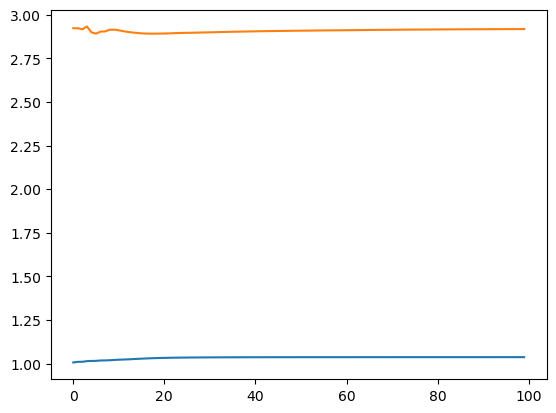

In [54]:
batch_size = 8
positive_dataloader = torch.utils.data.DataLoader(positive_dataset, batch_size=batch_size, shuffle=True)
negative_dataloader = torch.utils.data.DataLoader(negative_dataset, batch_size=batch_size, shuffle=True)
lr = 0.1
optimiser = torch.optim.AdamW(model.parameters(), lr, weight_decay=1.0)
epochs=100
Es, step = train(
    model,
    positive_dataloader,
    negative_dataloader,
    # optimiser,
    lr,
    epochs,
    step=step,
)
# plot logarithmic
for i, e in enumerate(Es):
    plt.plot(e)
# plt.yscale('log')
plt.show()

In [55]:
for i, e in enumerate(Es):
    print(max(e))

tensor(1.0375)
tensor(2.9327)


In [56]:
for layer in model.layers:
    print(layer.weight.abs().mean(), layer.bias.abs().mean())

tensor(0.0613, grad_fn=<MeanBackward0>) tensor(0.0634, grad_fn=<MeanBackward0>)
tensor(0.0312, grad_fn=<MeanBackward0>) tensor(0.0274, grad_fn=<MeanBackward0>)


In [57]:
positive_sample = positive_dataset[0][0].flatten().unsqueeze(0)
negative_sample = negative_dataset[0][0].flatten().unsqueeze(0)
random_sample = torch.randn_like(positive_sample)

out1 = model(positive_sample)
out2 = model(negative_sample)
out3 = model(random_sample)

print(out1[0][0].abs().mean())
print(out1[0][1].abs().mean())
print(out2[0][0].abs().mean())
print(out2[0][1].abs().mean())
print(out3[0][0].abs().mean())
print(out3[0][1].abs().mean())


tensor(1.0533)
tensor(2.9642)
tensor(1.0847)
tensor(2.9922)
tensor(0.9877)
tensor(2.7128)
